In [1]:
import pandas as pd
import numpy as np
from pandas import datetime
from matplotlib import pyplot as plt
import os

from statsmodels.tsa.arima_model import ARIMA
from matplotlib import pyplot
from pandas.plotting import autocorrelation_plot

from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX

import math

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import SimpleRNN
from keras.layers import Conv1D

In [2]:
import tensorflow as tf

In [9]:
plt.rcParams.update({'font.size': 22})
pd.set_option("display.max_columns", 4)

In [5]:
# Combining all blocks
for num in range(0,112):
    df = pd.read_csv("../Data_acquisition/Raw DB/household/energy/daily_dataset/block_"+str(num)+".csv")
    df = df[['day','LCLid','energy_sum']]
    df.reset_index()
    df.to_csv("hc_"+str(num)+".csv")

fout= open("energy.csv","a")
# first file:
for line in open("hc_0.csv"):
    fout.write(line)
# now the rest:    
for num in range(0,112):
    f = open("hc_"+str(num)+".csv")
    f.readline() # skip the header
    for line in f:
         fout.write(line)
    f.close()
fout.close()

In [6]:
energy = pd.read_csv('energy.csv')
len(energy)

3536007

In [10]:
energy.head()

,Unnamed: 0,day,LCLid,energy_sum
0,0,2012-10-12,MAC000002,7.098
1,1,2012-10-13,MAC000002,11.087
2,2,2012-10-14,MAC000002,13.223
3,3,2012-10-15,MAC000002,10.257
4,4,2012-10-16,MAC000002,9.769


In [11]:
#house count
housecount = energy.groupby('day')[['LCLid']].nunique()
print(len(housecount))
housecount.head(4)

829


,LCLid
day,
2011-11-23,13
2011-11-24,25
2011-11-25,32
2011-11-26,41


<AxesSubplot:title={'center':'Number of houses'}, xlabel='day'>

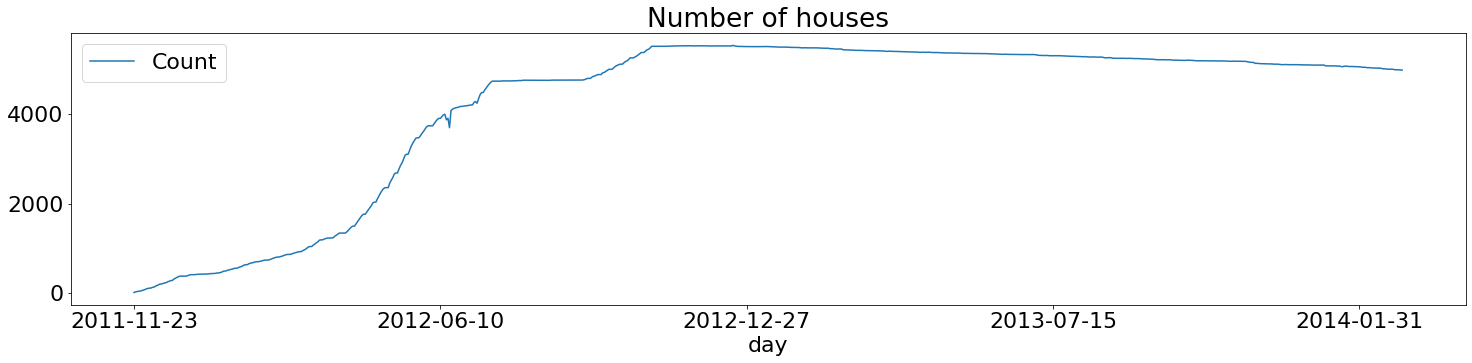

In [14]:
housecount = housecount.rename({"LCLid":"Count"},axis=1)
housecount.plot(figsize=(25,5),title = "Number of houses")

In [15]:
#energy per household
energy = energy.groupby('day')[['energy_sum']].sum()
energy = energy.merge(housecount, on = ['day'])
energy = energy.reset_index()

In [16]:
energy.count()

day           829
energy_sum    829
Count         829
dtype: int64

In [17]:
energy.day = pd.to_datetime(energy.day,format='%Y-%m-%d').dt.date

In [18]:
energy.head()

,day,energy_sum,Count
0,2011-11-23,90.385000,13
1,2011-11-24,213.412000,25
2,2011-11-25,303.993000,32
3,2011-11-26,420.976000,41
4,2011-11-27,444.883001,41


In [21]:
energy['avg_energy'] =  energy['energy_sum']/energy['Count']
print("Starting Point of Data at Day Level",min(energy.day))
print("Ending Point of Data at Day Level",max(energy.day))

Starting Point of Data at Day Level 2011-11-23
Ending Point of Data at Day Level 2014-02-28


In [22]:
energy.describe()

,energy_sum,Count,avg_energy
count,829.000000,829.000000,829.000000
mean,43535.325676,4234.539204,10.491862
std,20550.594031,1789.994799,1.902513
min,90.385000,13.000000,0.211766
25%,34665.436003,4084.000000,8.676955
50%,46641.160997,5138.000000,10.516983
75%,59755.616996,5369.000000,12.000690
max,84156.135002,5541.000000,15.964434


In [24]:
# Weather information
weather = pd.read_csv('../Data_acquisition/Raw DB/household/weather_daily_darksky.csv')
weather.head(4)

,temperatureMax,temperatureMaxTime,...,apparentTemperatureLowTime,moonPhase
0,11.96,2011-11-11 23:00:00,...,2011-11-11 19:00:00,0.52
1,8.59,2011-12-11 14:00:00,...,2011-12-12 08:00:00,0.53
2,10.33,2011-12-27 02:00:00,...,2011-12-28 00:00:00,0.10
3,8.07,2011-12-02 23:00:00,...,2011-12-02 19:00:00,0.25


In [25]:
weather.describe()

,temperatureMax,windBearing,...,apparentTemperatureMin,moonPhase
count,882.000000,882.000000,...,882.000000,882.000000
mean,13.660113,195.702948,...,5.738039,0.500930
std,6.182744,89.340783,...,6.048746,0.287022
min,-0.060000,0.000000,...,-8.880000,0.000000
25%,9.502500,120.500000,...,1.105000,0.260000
50%,12.625000,219.000000,...,4.885000,0.500000
75%,17.920000,255.000000,...,11.277500,0.750000
max,32.400000,359.000000,...,20.540000,0.990000


In [26]:
weather['day']=  pd.to_datetime(weather['time']) # day is given as timestamp
weather['day']=  pd.to_datetime(weather['day'],format='%Y%m%d').dt.date
# selecting numeric variables
weather = weather[['temperatureMax', 'windBearing', 'dewPoint', 'cloudCover', 'windSpeed',
       'pressure', 'apparentTemperatureHigh', 'visibility', 'humidity',
       'apparentTemperatureLow', 'apparentTemperatureMax', 'uvIndex',
       'temperatureLow', 'temperatureMin', 'temperatureHigh',
       'apparentTemperatureMin', 'moonPhase','day']]
weather = weather.dropna()

In [27]:
weather_energy =  energy.merge(weather,on='day')
weather_energy.head(2)

,day,energy_sum,...,apparentTemperatureMin,moonPhase
0,2011-11-23,90.385,...,2.18,0.94
1,2011-11-24,213.412,...,7.01,0.97


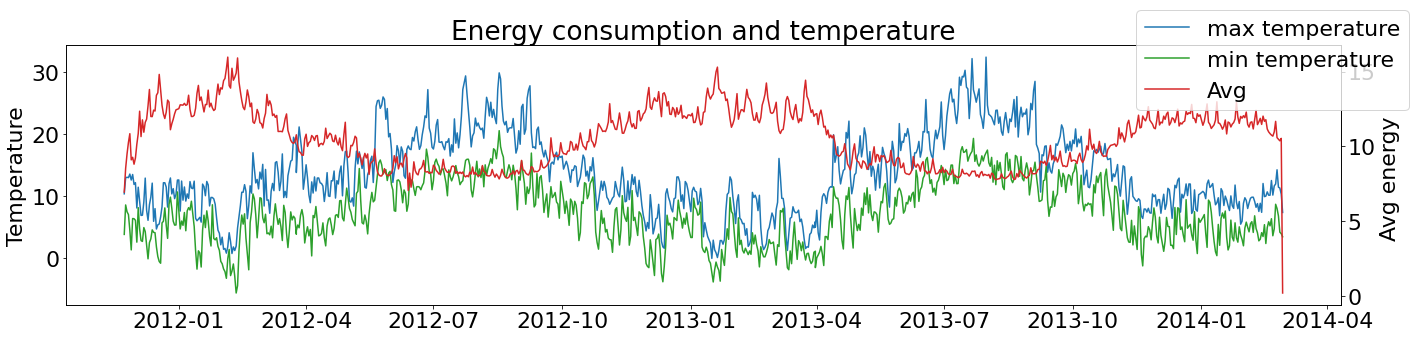

In [51]:
fig, ax1 = plt.subplots(figsize = (20,5))
ax1.plot(weather_energy.day, weather_energy.temperatureMax, color = 'tab:blue', label = "max temperature")
ax1.plot(weather_energy.day, weather_energy.temperatureMin, color = 'tab:green', label = "min temperature")
ax1.set_ylabel('Temperature')

ax2 = ax1.twinx()
ax2.plot(weather_energy.day,weather_energy.avg_energy,color = 'tab:red', label = "Avg")
ax2.set_ylabel('Avg energy ')
plt.title('Energy consumption and temperature')
fig.tight_layout()
fig.legend(loc="upper right")
plt.show()

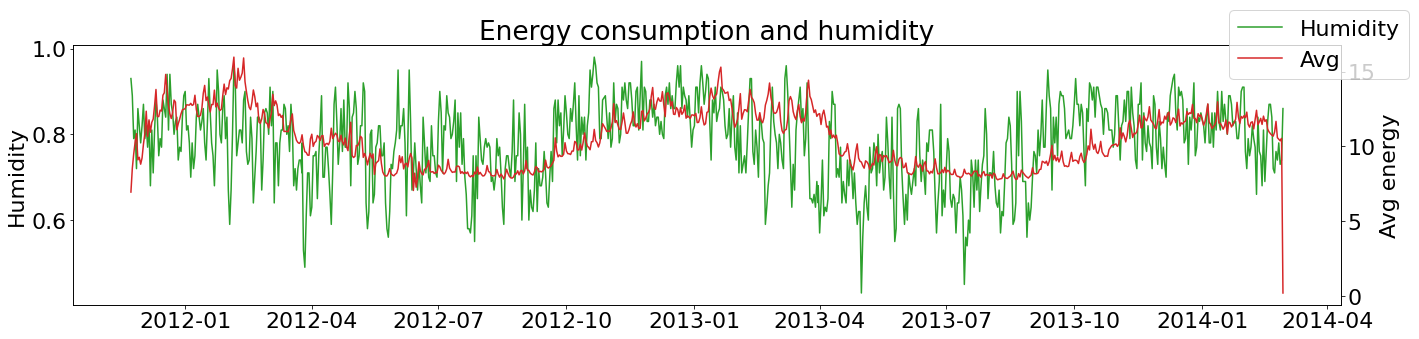

In [50]:
fig, ax1 = plt.subplots(figsize = (20,5))
ax1.plot(weather_energy.day, weather_energy.humidity, color = 'tab:green', label = "Humidity")
ax1.set_ylabel('Humidity')

ax2 = ax1.twinx()
ax2.plot(weather_energy.day,weather_energy.avg_energy,color = 'tab:red', label = "Avg")
ax2.set_ylabel('Avg energy')
plt.title('Energy consumption and humidity')
fig.legend(loc="upper right")
fig.tight_layout()
plt.show()

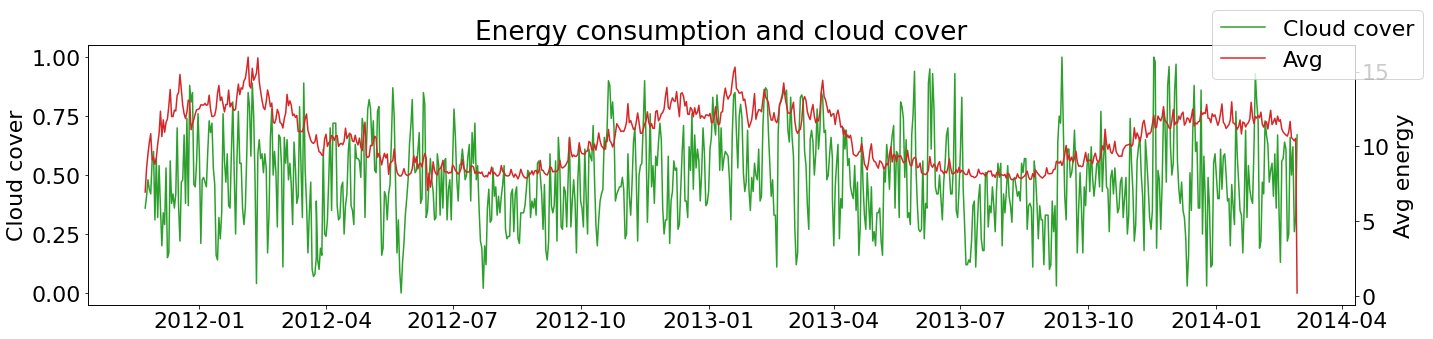

In [49]:
fig, ax1 = plt.subplots(figsize = (20,5))
ax1.plot(weather_energy.day, weather_energy.cloudCover, color = 'tab:green', label = "Cloud cover")
ax1.set_ylabel('Cloud cover')

ax2 = ax1.twinx()
ax2.plot(weather_energy.day,weather_energy.avg_energy,color = 'tab:red', label = "Avg")
ax2.set_ylabel('Avg energy')
plt.title('Energy consumption and cloud cover')
fig.legend(loc="upper right")
fig.tight_layout()
plt.show()

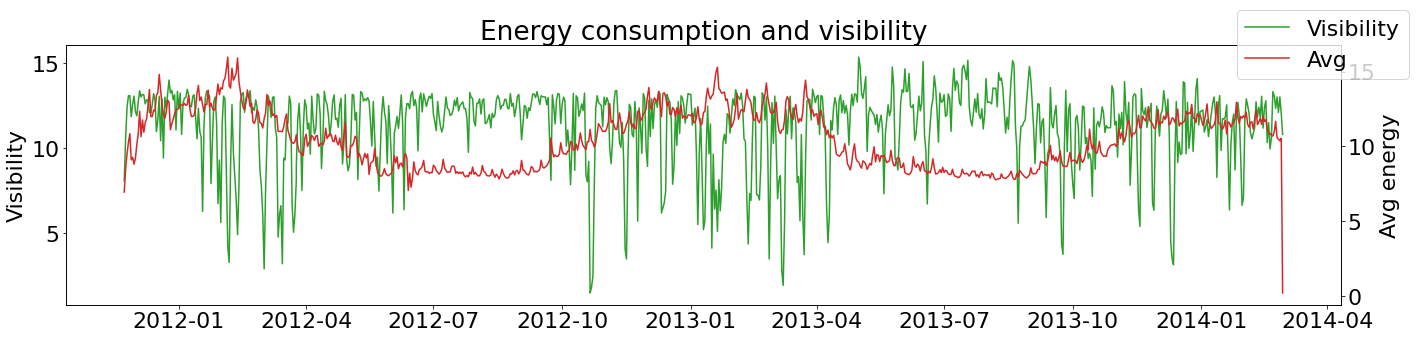

In [55]:
fig, ax1 = plt.subplots(figsize = (20,5))
ax1.plot(weather_energy.day, weather_energy.visibility, label = "Visibility", color = "tab:green")
ax1.set_ylabel('Visibility')

ax2 = ax1.twinx()
ax2.plot(weather_energy.day,weather_energy.avg_energy,color = 'tab:red', label = "Avg")
ax2.set_ylabel('Avg energy')
plt.title('Energy consumption and visibility')
fig.legend(loc="upper right")
fig.tight_layout()
plt.show()

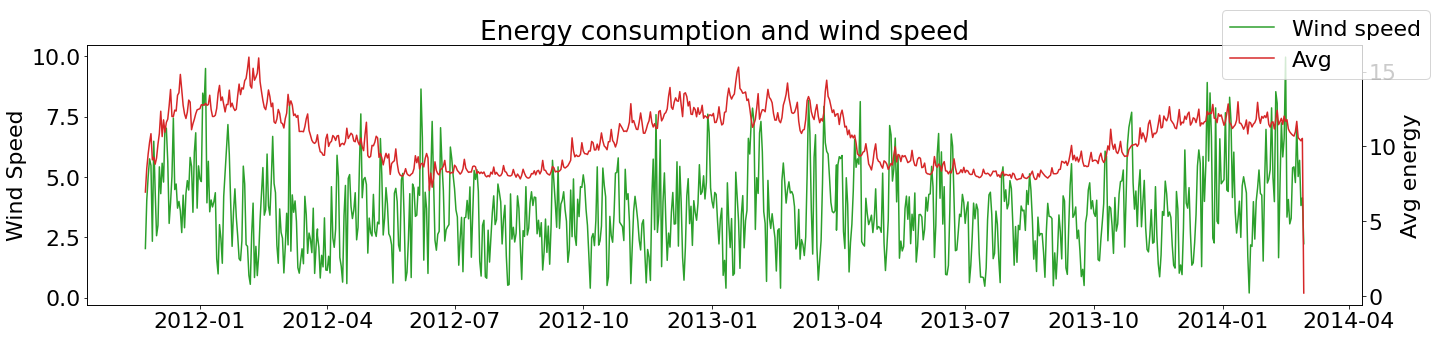

In [47]:
fig, ax1 = plt.subplots(figsize = (20,5))
ax1.plot(weather_energy.day, weather_energy.windSpeed, color = "tab:green", label = "Wind speed")
ax1.set_ylabel('Wind Speed')

ax2 = ax1.twinx()
ax2.plot(weather_energy.day,weather_energy.avg_energy, color = "tab:red" ,label = "Avg")
ax2.set_ylabel('Avg energy')
plt.title('Energy consumption and wind speed')
fig.legend(loc="upper right")
fig.tight_layout()
plt.show()

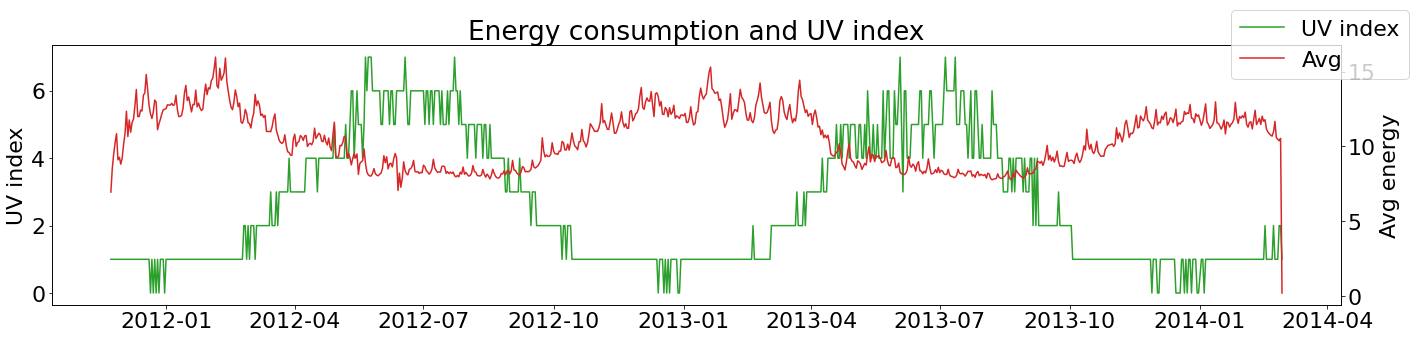

In [54]:
fig, ax1 = plt.subplots(figsize = (20,5))
ax1.plot(weather_energy.day, weather_energy.uvIndex, color = 'tab:green', label = "UV index")
ax1.set_ylabel('UV index')

ax2 = ax1.twinx()
ax2.plot(weather_energy.day,weather_energy.avg_energy,color = 'tab:red', label = "Avg")
ax2.set_ylabel('Avg energy')
plt.title('Energy consumption and UV index')
fig.legend(loc="upper right")
fig.tight_layout()
plt.show()

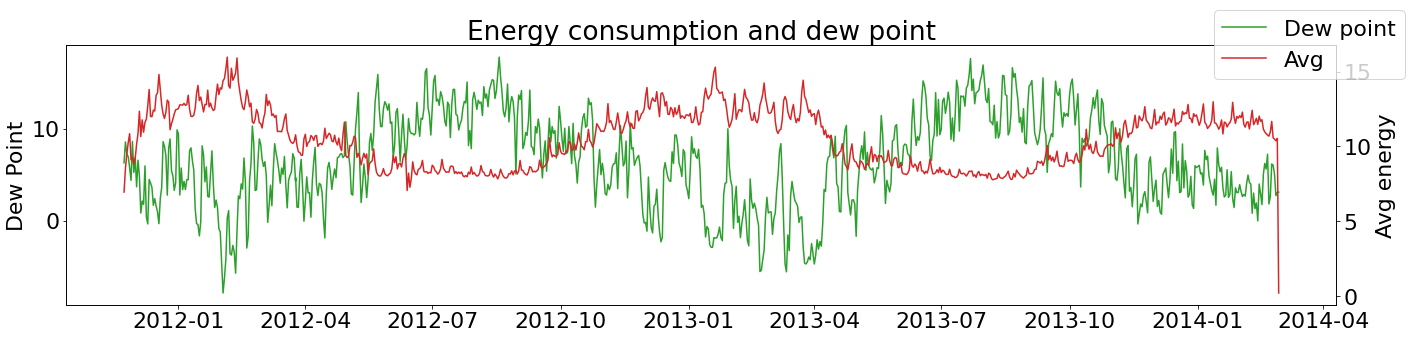

In [57]:
fig, ax1 = plt.subplots(figsize = (20,5))
ax1.plot(weather_energy.day, weather_energy.dewPoint, color = 'tab:green', label = "Dew point")
ax1.set_ylabel('Dew Point')

ax2 = ax1.twinx()
ax2.plot(weather_energy.day,weather_energy.avg_energy,color = 'tab:red', label = "Avg")
ax2.set_ylabel('Avg energy')
plt.title('Energy consumption and dew point')
fig.legend(loc="upper right")
fig.tight_layout()
plt.show()

In [25]:
#correlation

In [60]:
cor_matrix = weather_energy[['avg_energy','temperatureMax','dewPoint', 'cloudCover', 'windSpeed','pressure', 'humidity','uvIndex', 'moonPhase']].corr()
cor_matrix.style.background_gradient(cmap='coolwarm')

,avg_energy,temperatureMax,dewPoint,cloudCover,windSpeed,pressure,humidity,uvIndex,moonPhase
avg_energy,1.000000,-0.846965,-0.755901,0.241779,0.149624,-0.028851,0.361237,-0.733171,-0.031716
temperatureMax,-0.846965,1.000000,0.865038,-0.333409,-0.153602,0.118933,-0.404899,0.696497,0.003636
dewPoint,-0.755901,0.865038,1.000000,-0.025207,-0.092212,-0.028121,0.055514,0.486692,-0.008239
cloudCover,0.241779,-0.333409,-0.025207,1.000000,0.170235,-0.101079,0.480056,-0.248695,-0.062126
windSpeed,0.149624,-0.153602,-0.092212,0.170235,1.000000,-0.344354,-0.042391,-0.152634,-0.023273
pressure,-0.028851,0.118933,-0.028121,-0.101079,-0.344354,1.000000,-0.250941,0.100774,0.038462
humidity,0.361237,-0.404899,0.055514,0.480056,-0.042391,-0.250941,1.000000,-0.533919,-0.013997
uvIndex,-0.733171,0.696497,0.486692,-0.248695,-0.152634,0.100774,-0.533919,1.000000,0.012833
moonPhase,-0.031716,0.003636,-0.008239,-0.062126,-0.023273,0.038462,-0.013997,0.012833,1.000000


In [73]:
holiday = pd.read_csv('../Data_acquisition/Raw DB/household/uk_bank_holidays.csv')
holiday['Bank holidays'] = pd.to_datetime(holiday['Bank holidays'],format='%Y-%m-%d').dt.date
holiday

,Bank holidays,Type
0,2012-12-26,Boxing Day
1,2012-12-25,Christmas Day
2,2012-08-27,Summer bank holiday
3,2012-05-06,Queen?s Diamond Jubilee (extra bank holiday)
4,2012-04-06,Spring bank holiday (substitute day)
5,2012-07-05,Early May bank holiday
6,2012-09-04,Easter Monday
7,2012-06-04,Good Friday
8,2012-02-01,New Year?s Day (substitute day)
9,2013-12-26,Boxing Day


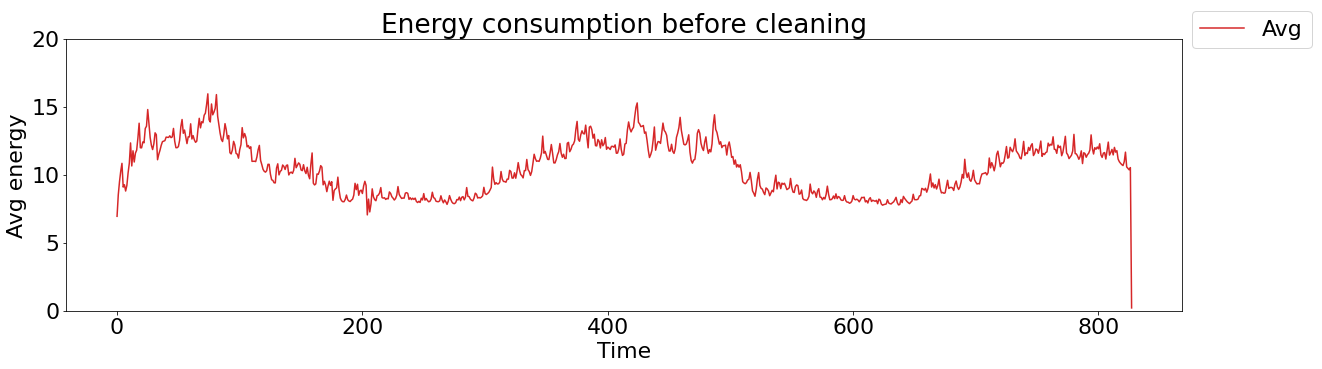

In [99]:
#we can see the error at the min value, it is too small in comparison to the mean value, which indicates that, it is an error
#we plot to see
fig, ax1 = plt.subplots(figsize = (20,5))
ax1.plot(np.arange(len(weather_energy.avg_energy)), weather_energy.avg_energy, color = "tab:red", label = "Avg")
ax1.set_ylim([0,20])
ax1.set_title("Energy consumption before cleaning")
ax1.set_ylabel("Avg energy")
ax1.set_xlabel("Time")
fig.legend(loc="upper right")

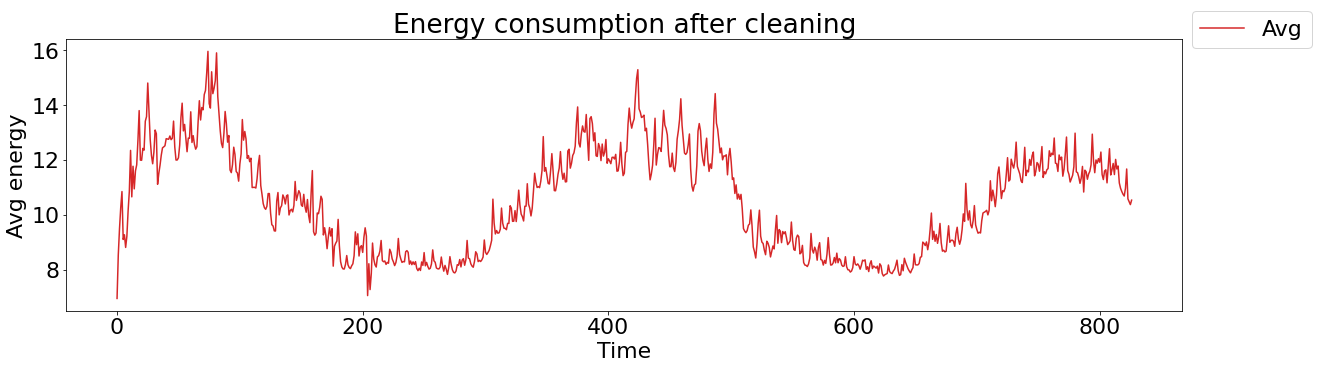

In [98]:
fig, ax1 = plt.subplots(figsize = (20,5))
ax1.plot(np.arange(len(weather_energy.avg_energy[:-1])), weather_energy.avg_energy[:-1], color = "tab:red", label = "Avg")
#ax1.set_ylim([0,20])
ax1.set_title("Energy consumption after cleaning")
ax1.set_ylabel("Avg energy")
ax1.set_xlabel("Time")
fig.legend(loc="upper right")